In [1]:
from datasets import load_dataset, concatenate_datasets, DatasetDict, load_from_disk

datasets = load_dataset("swag", "regular")
datasets = load_from_disk("swag.hf")
if False:
    # the labels for the test split are not public, therefore we create our own split
    # 60% train, 20% validation, 20% test
    merged_datasets = concatenate_datasets([datasets["train"], datasets["validation"]])
    
    train_testvalid = merged_datasets.train_test_split(test_size=0.4)
    # Split the 10% test + valid in half test, half valid
    test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
    # gather everyone if you want to have a single DatasetDict
    datasets = DatasetDict({
        'train': train_testvalid['train'],
        'test': test_valid['test'],
        'validation': test_valid['train']})
else: 
    datasets
#datasets.save_to_disk("swag.hf")

In [2]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=True)
batch_size = 16

In [3]:
ending_names = ["ending0", "ending1", "ending2", "ending3"]

def preprocess_function(examples):
    # Repeat each first sentence four times to go with the four possibilities of second sentences.
    first_sentences = [[context] * 4 for context in examples["sent1"]]
    # Grab all second sentences possible for each context.
    question_headers = examples["sent2"]
    second_sentences = [[f"{header} {examples[end][i]}" for end in ending_names] for i, header in enumerate(question_headers)]

    # Flatten everything
    first_sentences = sum(first_sentences, [])
    second_sentences = sum(second_sentences, [])

    # Tokenize
    tokenized_examples = tokenizer(first_sentences, second_sentences, truncation=True)
    # Un-flatten
    return {k: [v[i:i+4] for i in range(0, len(v), 4)] for k, v in tokenized_examples.items()}

In [4]:
encoded_datasets = datasets.map(preprocess_function, batched=True)

Map:   0%|          | 0/18710 [00:00<?, ? examples/s]

In [5]:
from transformers import TrainingArguments, Trainer, BertForMultipleChoice

model = BertForMultipleChoice.from_pretrained("bert-base-uncased")

Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
args = TrainingArguments(
    "bert-base-finetuned-swag",
    evaluation_strategy = "steps",
    eval_steps=1000,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
)


/home/e12117772/2024W-DLNLP-BERT/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [133]:
import torch
import torch.nn as nn

class BERTForSWAG(nn.Module):
    def __init__(self, bert_model):
        super(BERTForSWAG, self).__init__()
        self.bert = bert_model  # Pretrained BERT model
        self.hidden_size = bert_model.config.hidden_size  # e.g., 768 for BERT-base
        self.v = nn.Parameter(torch.randn(self.hidden_size))  # Learnable vector

    def forward(self, input_ids, attention_mask, lables=None):
        # input_ids: (batch_size, 4, seq_len)
        # attention_mask: (batch_size, 4, seq_len)

        batch_size, num_choices, seq_len = input_ids.shape

        # Flatten the inputs for BERT: (batch_size * 4, seq_len)
        input_ids = input_ids.view(-1, seq_len)
        attention_mask = attention_mask.view(-1, seq_len)

        # Pass through BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, lables = lables)

        # Extract [CLS] token representation: (batch_size * 4, hidden_size)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]  # [CLS] is at index 0

        # Reshape back: (batch_size, 4, hidden_size)
        cls_embeddings = cls_embeddings.view(batch_size, num_choices, self.hidden_size)

        # Compute dot product with the learnable vector v: (batch_size, 4)
        logits = torch.matmul(cls_embeddings, self.v)

        # Apply softmax over the 4 choices
        probs = torch.softmax(logits, dim=1)

        return probs

custom_model = BERTForSWAG(model)

In [7]:
from dataclasses import dataclass
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from typing import Optional, Union
import torch

@dataclass
class DataCollatorForMultipleChoice:
    """
    Data collator that will dynamically pad the inputs for multiple choice received.
    """

    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None

    def __call__(self, features):
        label_name = "label" if "label" in features[0].keys() else "labels"
        labels = [feature.pop(label_name) for feature in features]
        batch_size = len(features)
        num_choices = len(features[0]["input_ids"])
        flattened_features = [[{k: v[i] for k, v in feature.items()} for i in range(num_choices)] for feature in features]
        flattened_features = sum(flattened_features, [])

        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        # Un-flatten
        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
        # Add back labels
        batch["labels"] = torch.tensor(labels, dtype=torch.int64)
        return batch

In [8]:
accepted_keys = ["input_ids", "attention_mask", "label"]
features = [{k: v for k, v in encoded_datasets["train"][i].items() if k in accepted_keys} for i in range(10)]
batch = DataCollatorForMultipleChoice(tokenizer)(features)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [9]:
import numpy as np

def compute_metrics(eval_predictions):
    predictions, label_ids = eval_predictions
    preds = np.argmax(predictions, axis=1)
    return {"accuracy": (preds == label_ids).astype(np.float32).mean().item()}

In [13]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_datasets["train"],
    eval_dataset=encoded_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=DataCollatorForMultipleChoice(tokenizer),
    compute_metrics=compute_metrics,
)


/tmp/ipykernel_2421/3095340611.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [14]:
train = trainer.train()

Step,Training Loss,Validation Loss,Accuracy
1000,0.787400,0.747749,0.708979
2000,0.763700,0.690339,0.730465
3000,0.727700,0.674756,0.742651
4000,0.436200,0.725706,0.746072
5000,0.430800,0.690494,0.752913
6000,0.412300,0.715735,0.758418
7000,0.416600,0.679938,0.764244
8000,0.231500,0.864792,0.760342
9000,0.232800,0.877768,0.764458
10000,0.217000,0.898758,0.765473


In [15]:
evaluated = trainer.evaluate()
evaluated

{'eval_loss': 0.8863919973373413,
 'eval_accuracy': 0.7659006118774414,
 'eval_runtime': 55.7675,
 'eval_samples_per_second': 335.5,
 'eval_steps_per_second': 20.98,
 'epoch': 3.0}

In [16]:
import pandas as pd
training_history_bert_base = pd.DataFrame(trainer.state.log_history)
training_history_bert_base.epoch = training_history_bert_base.epoch.astype(int)
training_history_bert_base.groupby("epoch").first()

,loss,grad_norm,learning_rate,step,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
epoch,,,,,,,,,,,,,,
0,0.2098,6.016766,0.000019,500,0.747749,0.708979,55.7392,335.671,20.991,NaN,NaN,NaN,NaN,NaN
1,0.4362,15.977107,0.000012,4000,0.725706,0.746072,55.9190,334.591,20.923,NaN,NaN,NaN,NaN,NaN
2,0.2439,19.795322,0.000006,7500,0.864792,0.760342,55.9597,334.348,20.908,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,10527,0.886392,0.765901,55.7675,335.500,20.980,2168.9288,77.639,4.854,1.892858e+16,0.441827


In [17]:
test_pred = trainer.predict(encoded_datasets["test"])
test_pred.metrics

{'test_loss': 0.8953481316566467,
 'test_accuracy': 0.7613703012466431,
 'test_runtime': 57.0514,
 'test_samples_per_second': 327.967,
 'test_steps_per_second': 20.508}

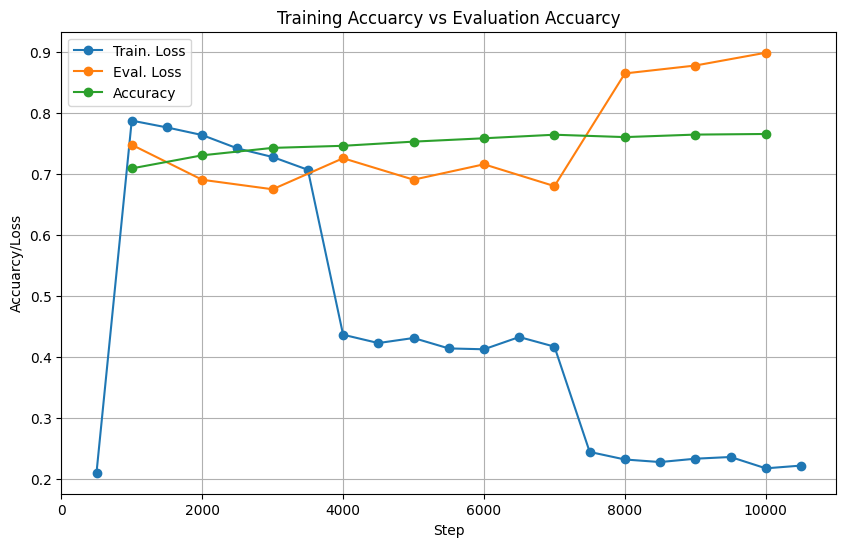

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare the data
data = training_history_bert_base[["loss", "eval_loss", "step", "eval_accuracy"]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Steps", "Accuracy"]
data = data[:-1]  # drop last row
data = pd.melt(data, ['Training Steps']).dropna()

# Plot using Matplotlib
plt.figure(figsize=(10, 6))

# Plot each variable separately without using groupby
train_loss = data[data['variable'] == "Train. Loss"]
eval_loss = data[data['variable'] == "Eval. Loss"]
acc = data[data['variable'] == "Accuracy"]

plt.plot(train_loss["Training Steps"], train_loss["value"], marker='o', label="Train. Loss")
plt.plot(eval_loss["Training Steps"], eval_loss["value"], marker='o', label="Eval. Loss")
plt.plot(acc["Training Steps"], acc["value"], marker='o', label="Accuracy")

# Labels and Title
plt.ylabel('Accuarcy/Loss')
plt.xlabel('Step')
plt.title('Training Accuarcy vs Evaluation Accuarcy')
plt.legend()
plt.grid(True)

# Show plot
plt.savefig('bert_base_swag_finetuned.png')


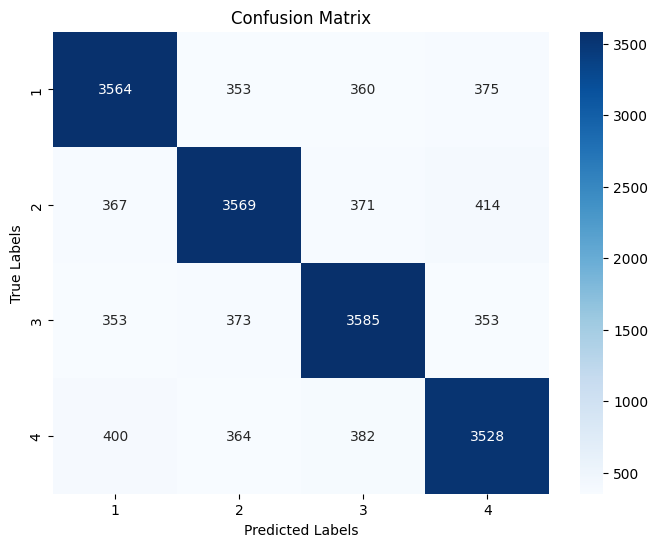

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

import evaluate

metric = evaluate.load("confusion_matrix")

predictions = np.argmax(test_pred.predictions, axis=-1)
metric.add_batch(predictions=predictions, references=datasets["test"]["label"])

# Compute confusion matrix
conf_matrix = metric.compute()['confusion_matrix']

# Define class labels manually (adjust as needed)
labels = ["1", "2", "3", "4"]

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('swag_bert_base_confusion_matrix.png')
